In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

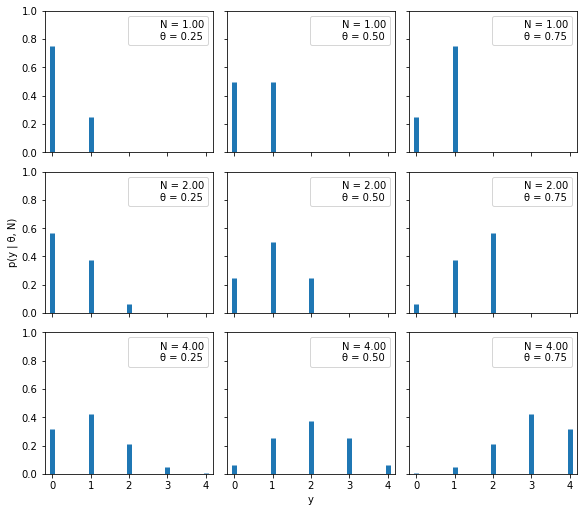

In [2]:
n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = np.arange(0, max(n_params)+1)
f,ax = plt.subplots(len(n_params), len(p_params), sharex=True, 
                    sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = stats.binom(n=n, p=p).pmf(x)

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)


### Choosing the prior

As a prior we will use a beta distribution, which is a very common distribution:

\begin{equation}
p\left(\theta\right) = \frac{\Gamma\left(\alpha+\beta\right)}{\Gamma\left(\alpha\right)\Gamma\left(\beta\right)}\theta^(\alpha - 1)\left(1-\theta\right)^{\beta -1}
\end{equation}

The beta distribution is a common choice of prior in Bayesian statistics:

Text(0.07, 0.5, &#39;p(θ)&#39;)

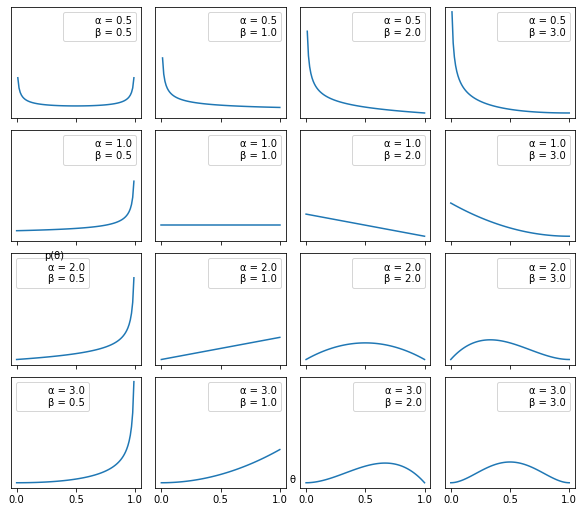

In [3]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, 
                     sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, 
                     b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)

A beta distribution is a conjugate prior of the binomial distribution. A conjugate prior of a likelihood is a prior, when used in combination with a given likelihod, returns a posterior with the same functional form as the prior. e.g. if we use the beta distribution as our likelihood function then if our prior is a binomial distribution so will our posterior be.

## Getting the posterior

\begin{equation}
p\left(\theta | y\right) \propto \frac{N!}{y!\left(N-y\right)!}\theta^y\left(1-\theta\right)^{N-y}\frac{\Gamma\left(\alpha+\beta\right)}{\Gamma\left(\alpha\right)\Gamma\left(\beta\right)}\theta^{\alpha - 1}\left(1-\theta\right)^{\beta -1}
\end{equation}

## Computing and plotting the posterior

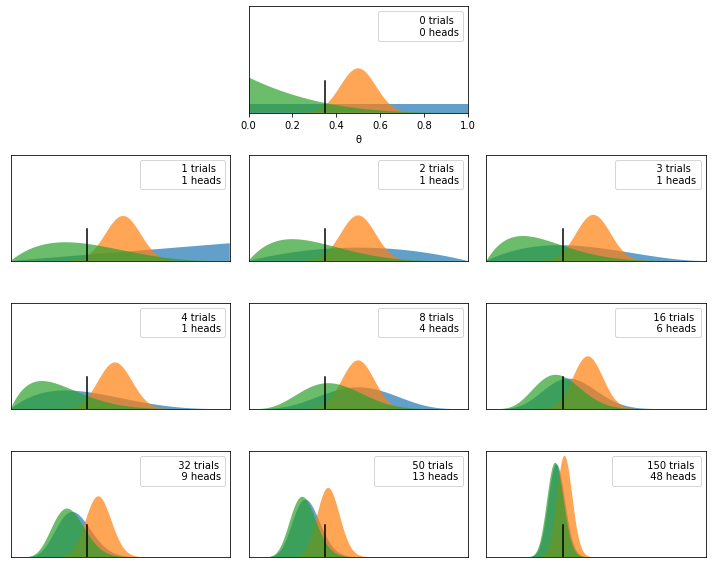

In [4]:
plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = stats.beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()

## Highest Posterior Density (HPD)



In [5]:
import arviz as az

array([&lt;AxesSubplot:title={&#39;center&#39;:&#39;θ&#39;}&gt;], dtype=object)

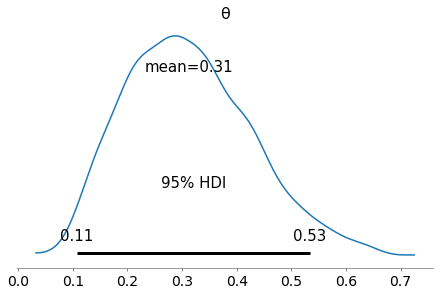

In [6]:
np.random.seed(1)
az.plot_posterior({'θ':stats.beta.rvs(5, 11, size=1000)}, credible_interval=0.95)

# Trying PyMC3

### Flipping some coins

In [7]:
# Get some fake coin flip data
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

In [8]:
# Let us import pymc3
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


&lt;IPython.core.display.HTML object&gt;

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8834800167483259, but should be close to 0.8. Try to increase the number of tuning steps.


array([[&lt;AxesSubplot:title={&#39;center&#39;:&#39;θ&#39;}&gt;,
        &lt;AxesSubplot:title={&#39;center&#39;:&#39;θ&#39;}&gt;]], dtype=object)

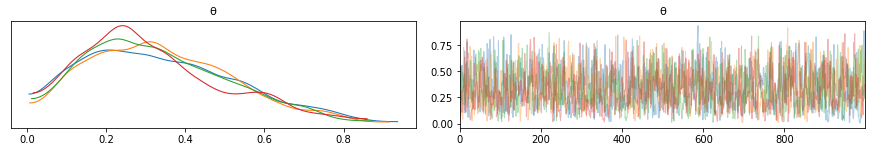

In [10]:
az.plot_trace(trace)

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.331,0.18,0.023,0.656,0.005,0.003,1430.0,1430.0,1354.0,1668.0,1.0


array([&lt;AxesSubplot:title={&#39;center&#39;:&#39;θ&#39;}&gt;], dtype=object)

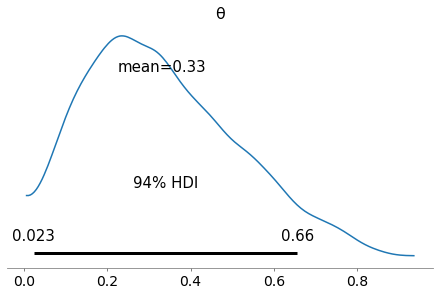

In [12]:
az.plot_posterior(trace)

## ROPE (Region of Practical Equivalence)

array([&lt;AxesSubplot:title={&#39;center&#39;:&#39;θ&#39;}&gt;], dtype=object)

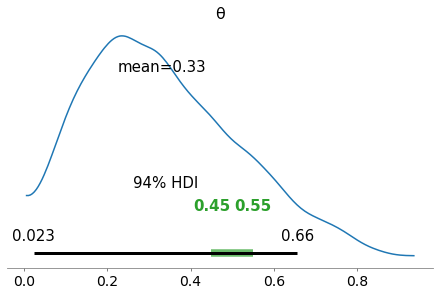

In [13]:
az.plot_posterior(trace, rope=[0.45, 0.55])

## Reference Value

We can also check againsts a reference value to compare with 

array([&lt;AxesSubplot:title={&#39;center&#39;:&#39;θ&#39;}&gt;], dtype=object)

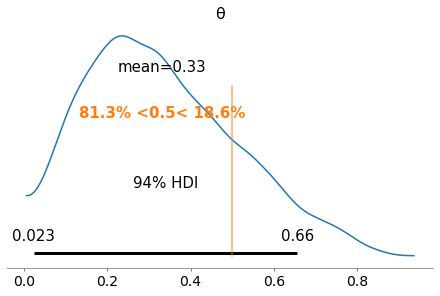

In [14]:
az.plot_posterior(trace, ref_val=0.5)

## Loss functions

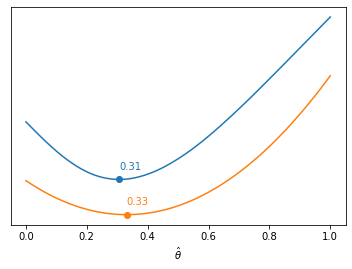

In [15]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

The first value is equal to the median of the posterior and the second value is equal to the mean of the posterior.

In [16]:
np.median(θ_pos)

0.3079597324065309

In [17]:
np.mean(θ_pos)


0.33113512743140744

This basically implies that different loss functions corresponds to different point estimates.

## Gaussian Inferences

([&lt;matplotlib.axis.YTick at 0x130c1dd7940&gt;], [Text(0, 0, &#39;&#39;)])

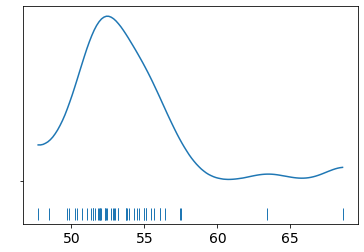

In [18]:
data = np.loadtxt('../data/chemical_shifts.csv')
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

Since the we do not know the mean and the standard deviation, we must set priors for both of them. A reasonable model could be:

\begin{equation}
\mu\sim U\left(l,h\right) \\
\sigma \sim N\left(0, \sigma_0\right)\\
y \sim N\left(\mu, \sigma\right)
\end{equation}

where $\mu$ comes from a uniform distribution with boundaries $l$ and $h$, which are the lower and upper bounds respectively. A half normal distribution is like a normal distribution but restricted to positive values. Let us construct the functions using pymc3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


&lt;IPython.core.display.HTML object&gt;

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


array([[&lt;AxesSubplot:title={&#39;center&#39;:&#39;μ&#39;}&gt;,
        &lt;AxesSubplot:title={&#39;center&#39;:&#39;μ&#39;}&gt;],
       [&lt;AxesSubplot:title={&#39;center&#39;:&#39;σ&#39;}&gt;,
        &lt;AxesSubplot:title={&#39;center&#39;:&#39;σ&#39;}&gt;]], dtype=object)

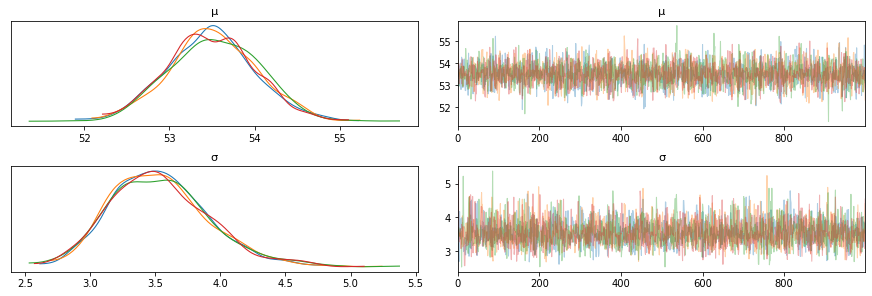

In [19]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)
az.plot_trace(trace_g)

In the above example the posterior is bi-dimensional. Thus the arviz plots only the marginal posterior distributions. we can do the bi-dimensional posterior distribution plot as follows:

&lt;AxesSubplot:xlabel=&#39;μ&#39;, ylabel=&#39;σ&#39;&gt;

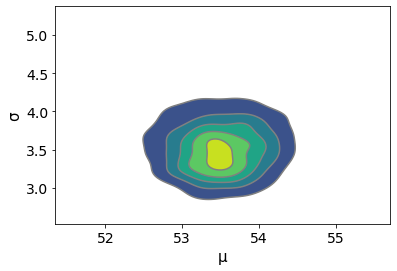

In [20]:
pm.pairplot(trace_g, kind='kde')

In [21]:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.508,0.514,52.561,54.483,0.009,0.006,3559.0,3556.0,3561.0,2801.0,1.0
σ,3.538,0.379,2.845,4.225,0.006,0.004,3575.0,3547.0,3591.0,2866.0,1.0


## Posterior Predictive Check

let's check how our model stacks up against the real data and good was it at approximating it:

In [22]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y&#39;s shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


&lt;matplotlib.legend.Legend at 0x130c41cf320&gt;

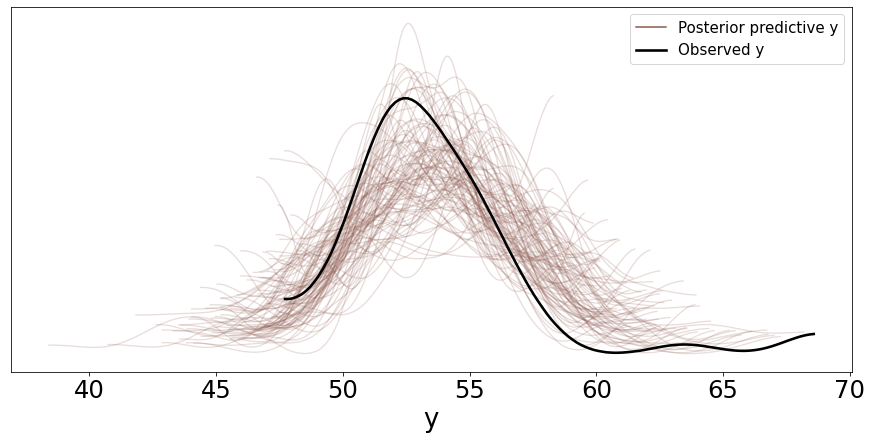

In [23]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)

In [24]:
y_pred_g['y'].shape

(100, 48)

## Robust Inferences

We saw that the presence of the two extra points in the right resulted in the overall posterior getting shifted from the original distribution. One of the ways to address this is to find out whether these points are outliers or not. There are several ways to identify outliers and remove them.

## Student's t-distribution
One way to deal with Gaussian is to use t-distribution instead. The distribution has three parameters, the mean, the scale (analagous to the standard deviation), and the degrees of freedom referred to by the letter $\nu$, let us call this the normality parameter.

When $\nu=1$, we get very heavy tails, which is also known as the Cauchy or the Lorentz distribution.

(-5.0, 5.0)

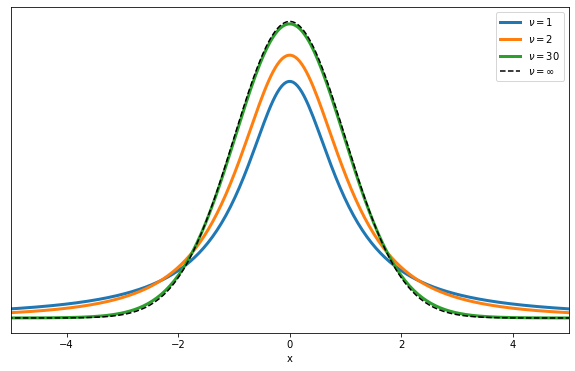

In [25]:
np.mean(stats.t(loc=0, scale=1, df=1).rvs(100)) 
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

We are now going to rewrite the previous model by replacing with the following:

\begin{equation}
\mu \sim U\left(l,h\right)\\
\sigma \sim |N\left(0, \sigma_{\sigma}\right)|\\
\nu \sim Exp\left(\lambda\right)\\
y \sim T\left(\mu, \sigma, \nu\right)
\end{equation}

The Student's t distribution has one more parameter $\left(\nu\right)$ compared to the Gaussian distribution hence requires us to declare one more prior. We can now rewrite this in pymc3 as:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


&lt;IPython.core.display.HTML object&gt;

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
The acceptance probability does not match the target. It is 0.8786472988345526, but should be close to 0.8. Try to increase the number of tuning steps.


array([[&lt;AxesSubplot:title={&#39;center&#39;:&#39;μ&#39;}&gt;,
        &lt;AxesSubplot:title={&#39;center&#39;:&#39;μ&#39;}&gt;],
       [&lt;AxesSubplot:title={&#39;center&#39;:&#39;σ&#39;}&gt;,
        &lt;AxesSubplot:title={&#39;center&#39;:&#39;σ&#39;}&gt;],
       [&lt;AxesSubplot:title={&#39;center&#39;:&#39;ν&#39;}&gt;,
        &lt;AxesSubplot:title={&#39;center&#39;:&#39;ν&#39;}&gt;]], dtype=object)

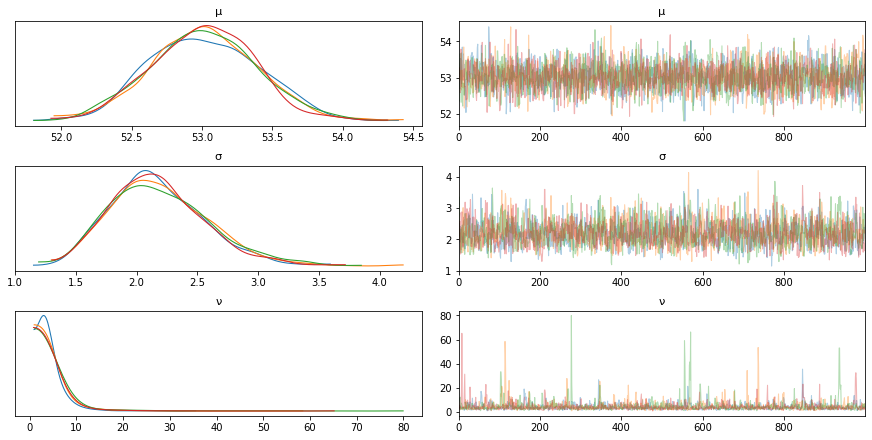

In [26]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
az.plot_trace(trace_t)


In [27]:
az.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.015,0.375,52.284,53.677,0.007,0.005,2891.0,2891.0,2888.0,2765.0,1.0
σ,2.185,0.395,1.451,2.886,0.009,0.006,1853.0,1853.0,1850.0,2235.0,1.0
ν,4.634,4.290,1.102,9.239,0.106,0.075,1636.0,1636.0,1913.0,1911.0,1.0


We can see that the scaling is 2.185 instead of 3.538. The normality score 4.634 also means that the distribution is more tail heavy. We can now plot the posterior and see how this compares to the original distribution:

&lt;IPython.core.display.HTML object&gt;

arviz.data.io_pymc3 - WARNING - posterior predictive variable y&#39;s shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(40.0, 70.0)

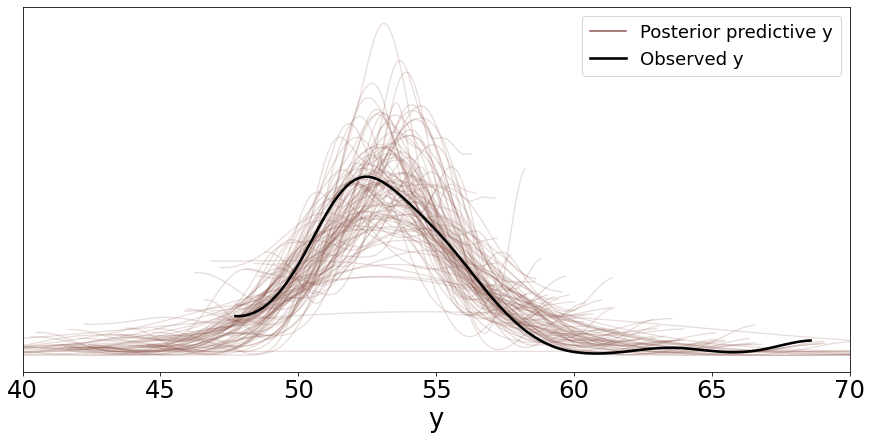

In [28]:
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)

Using the student's t distribution seems to be a better fit for the current data.

## Groups comparison

We are going to focus on effect size, that is quantifying the difference between two groups. The idea is to understand how well an experiment worked not whether it worked or not.

Especially when it comes to comaparing the effect of a drug, we have a control group and we have treatment group. The treatment group is the group to whom the new drug is administered and the control group is given placebo's.

Sometimes you would want to measure whether a new drug has better efficacy compared to an existing drug. In that case, the control group would be administered the already existing drug.

To compare two groups we must decide on which feature (or features) we would want to compare. A very commonly used feature is the mean of each group. While working in the Bayesian regime, we will work to obtaine the posterior of the differences of the means between groups and not just a point estimate of the differences.To help us see and interpret such a posterior, we are going to use three set of tools:
    - A posterior with a reference value
    - The Cohen's d
    - The probability of superiority.